# **Laboratorio 9: Predicción en series de tiempo**
**Facultad de ingeniería, departamento de Ingeniería Biomédica, Universidad de los Andes**\
**IBIO-2440 Programación científica**

**Nombres de los integrantes**


1.   David Tobón Molina
2.   David Santiago Rodríguez Quiroga

**Número del grupo**

Grupo 2

# **Contexto del problema**

El análisis cinemático en ciclismo se divide en dos metodología generales: una que se basa en una medición de ángulos de las articulaciones en un plano bidimensional y otra basa en un entorno tridimensional. El análisis bidimensional ofrece una información limitada debido a que solo es posible registrar álgulos de uno de los lados del cuerpo divido en el plago sagital, mientras que el tridimensional ofrece la posibilidad de registrar múltiples ángulos sobre todo el cuerpo. La limitación principal del segundo método es el costo asociado al uso de los equipos, el cual es drásticamente más elevado que el primero debido a que requiere un sistema de cámaras infrarojas ubicadas en un entorno de medición en 360 grados con un software especializado. Por otro lado, el método bidimensional solo requiere la grabación del sujeto con marcadores ubicados en principalmente en las articulaciones para ser procesada a través de paquetes de software que usualmente tienen licencias gratuitas para entornos académicos. Los ángulos medidos son como los que semuestran en la siguiente imagen:
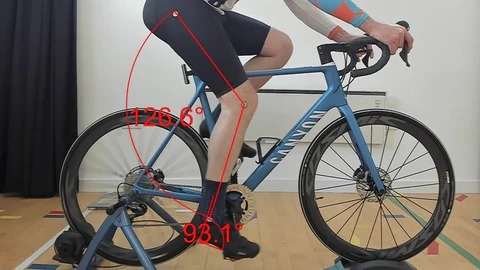 

La información de flexión de las articulaciones se  utiliza usualmente para determinar si el ajuste de la bicicleta al sujeto es adecuada o si, de acuerdo con desbalances u oscilaciones, es neceario reajustarla. Este ajuste se denomina en ciclismo como bikefitting, y es fundamental tanto para deportistas profesionales como para casuales en la reducción del riesgo de sufrir lesiones a corto y largo plazo. 


# **Descripción de la práctica**
En esta práctica se usarán los datos reales observados de los ángulos de flexión de la rodilla izquierda y la derecha de un sujeto en un estudio cinemático de ciclismo sobre una bicicleta estática. Estos datos fueron adquiridos usando un equipo de medición 3D durante 30 segundos en el laboratorio de movimiento del departamento de ingeniería biomédica de la Universidad de los Andes. Usando estos datos, se desea crear un modelo de regresión que permita predecir el comportamiento de la rodilla izquierda a partir de la observación del movimiento de la rodilla derecha. Este modelo permitirá hacer un análisis más extenso usando un equipo de medición 2D fuera del laboratorio de movimiento. En otras palabras, el objetivo de esta práctica es crear un modelo que, a partir de los datos de flexión de la rodilla derecha, pueda predecir el comportamiento de la rodilla izquierda. 

Sea $R(k)$ el ángulo de flexión para la rodilla derecha tomado en el instante de tiempo $k$, y sea $L(k)$ el ángulo de flexión de rodilla izquierda en el instante de tiempo $k$. La ecuación de diferencias que define la relación entre $R$ y $L$ se asume de la siguiente manera:

\begin{align*}
  L(k) = \beta_1R(k) +\beta_2R(k-1) + \beta_3R(k-2) + \cdots +  \beta_nR(k-n+1).
\end{align*}



Esta ecuación permite predecir el ángulo de flexión de la rodilla izquierda a partir de la historia de la rodilla derecha, donde $n$ es el tamaño de ventana. 

Para llevar a cabo todo el ejercicio de predición en series de tiempo, siga los siguientes pasos:

1. Lea y procese los datos en formato *xlsx* del documento "*train.xlsx*". Este contiene la lectura de los ángulos de flexión de las rodillas izquierda y derecha. Grafique la serie de tiempo del ángulo de flexión de las rodilla derecha y de la serie de tiempo del ángulo de flexión de la rodilla izquierda. Note que estas comienzan con un error de medición al inicio, asegurese de eliminar esta zona.

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def graph_knee_angle_data(left_knee_data, right_knee_data):

    plt.plot(left_knee_data)
    plt.xlabel("Instante de tiempo")
    plt.ylabel("Ángulo de flexión de rodilla izquierda")
    plt.show()

    plt.plot(right_knee_data)
    plt.xlabel("Instante de tiempo")
    plt.ylabel("Ángulo de flexión de rodilla derecha")
    plt.show()
    
    plt.plot(list(range(len(left_knee_data))), left_knee_data, label="Rodilla izquierda")
    plt.plot(list(range(len(right_knee_data))), right_knee_data, label="Rodilla derecha")
    plt.legend()
    plt.show()  

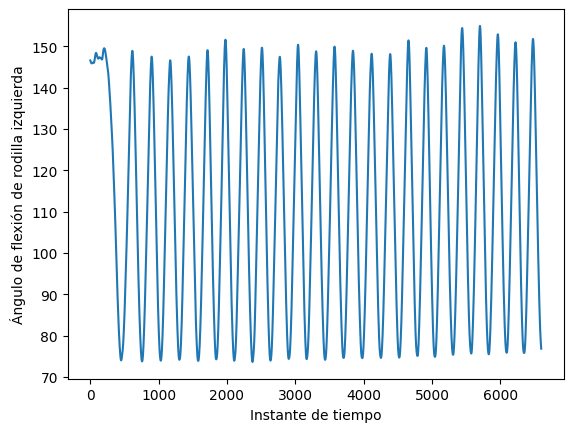

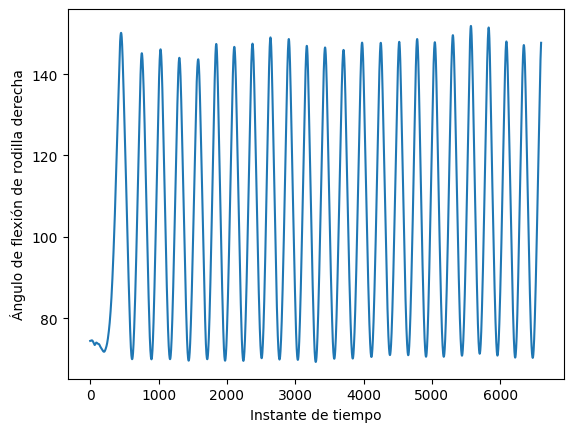

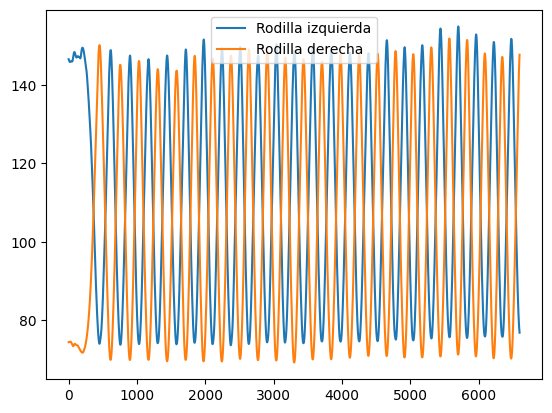

Eliminar zona de error:


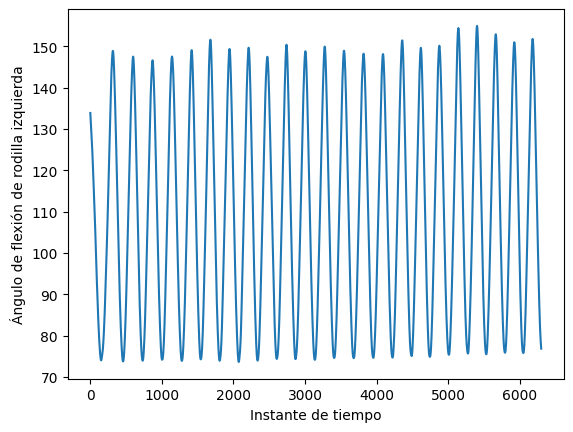

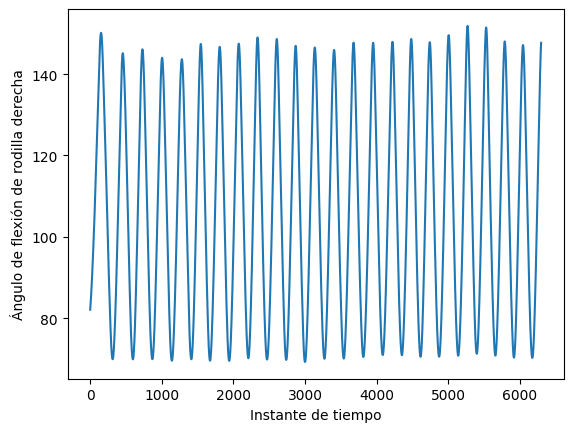

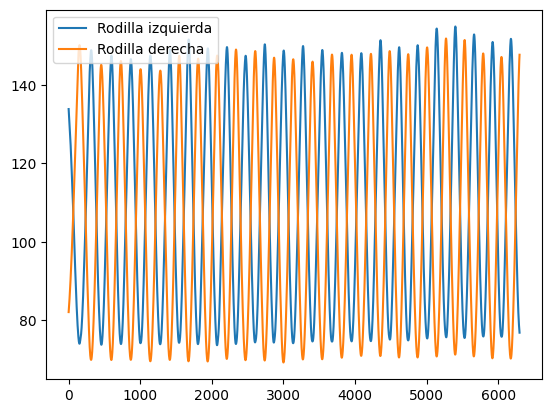

In [310]:
train_data = pd.read_excel("train.xlsx", header=None)

right_knee_data = train_data[0].to_numpy()
left_knee_data = train_data[1].to_numpy()

graph_knee_angle_data(right_knee_data, left_knee_data)

print("Eliminar zona de error:")
right_knee_data = np.delete(right_knee_data, list(range(300)))
left_knee_data = np.delete(left_knee_data, list(range(300)))

graph_knee_angle_data(right_knee_data, left_knee_data)

2. Diseñe una función que permita constuir la matriz $H$ y el vector $Y$ asociadas al problema de regresión planteado con un tamaño de ventana genérico $n$. Tenga en cuenta que la matriz $H$ utiliza la información de la rodilla derecha $R$ y el vector $Y$ utiliza la información de la rodilla izquierda $L$. Dicha función debe tener como entrada el set de datos y el tamaño de ventana $n$, y debe retornar el vector  $\beta^*=[\beta_1^*,\beta_2^*,\cdots,\beta_n^*]^T$ óptimo resolviendo el problema de mínimos cuadrados.

In [311]:
def get_h_and_y(data, n):

    x = data[0]
    y = data[1]
    
    # H y Y asociadas a n
    y_n = y[:len(y)-n+1]
    H = np.zeros((len(x)-n+1, n))
    
    for i in range(len(H)):
        H[i] = x[i:i+n]
        
    return H, y_n


def get_beta_star(data, n):
    """
        data : data set: (x, y)
        n : window size
    
    Returns:
        np.array : β* vector β* = [β*_1, β*_2, ... , β*_n].T
    """
    
    # H y Y asociadas a n
    H, y_n = get_h_and_y(data, n)
                
    H_mul = np.dot(H.T, H)
    
    try:
        beta_star = np.linalg.inv(H_mul).dot(H.T).dot(y_n)
    except np.linalg.LinAlgError:
        print("Matriz no invertible")
                
    return beta_star

3. Con los datos de entrenamiento, encuentre los valores $\beta^*=[\beta_1^*,\beta_2^*,\cdots,\beta_n^*]^T$ óptimos. Con los siguientes tamaños de ventana:

 - $n_1$ = 4
 - $n_2$ = 20
 - $n_3$ = 100

In [312]:
n_list = list(range(3,200))
n_to_graph = [4, 20, 100]
beta_star_list = []

for n in n_list:
    beta_star = get_beta_star((left_knee_data, right_knee_data), n)
    beta_star_list.append(beta_star)
    if n in n_to_graph:
        print(beta_star)

[ 1436.14184517 -1329.17066596 -1649.9007655   1543.93766616]
[ 5832.97958199 -6408.23463975 -5022.88175073   245.06777579
  3290.62966507  3637.01361096  3077.53163479   912.66634441
 -1532.51477726 -4004.27961831 -4058.51833721 -1630.80077897
   880.4375976   3153.31573676  3770.11324833  3428.06843195
   237.62140187 -5211.71806213 -6710.08431883  6114.60378732]
[ 5.63386566e+02 -9.50442866e+02  1.46860551e+02  4.69107129e+02
 -1.70893462e+03  3.27322709e+03 -2.80535448e+03  1.90910137e+03
 -1.03493945e+03  1.31688800e+02 -7.86233654e+01  1.35758532e+02
 -4.36741562e+02  4.62821427e+02  1.62402102e+02 -6.40702947e+02
  7.75321322e+02 -5.97425152e+02  4.97564435e+02 -3.07479591e+02
 -1.15324632e+02  1.98828312e+02 -2.59974899e+01 -2.15328951e+01
  2.82743812e+00 -1.20997796e+01  2.17595429e+00 -9.63378120e+01
  4.58993252e+01  2.49147709e+02 -3.50322755e-01 -7.63890673e+02
  9.94334489e+02 -5.13895981e+02  1.18869605e+02 -6.68919731e+01
  6.53329167e+01 -3.95880363e+01 -7.17754202e+0

4. Ahora se disponen de unos datos nuevos de flexión de rodilla derecha obtenidos usando un equipo de medición 2D. Lea y procese los datos del documento "*pred.xlsx*".

In [313]:
pred_data_df = pd.read_excel("pred.xlsx", header=None)
pred_data = pred_data_df.to_numpy()

5. Con los datos de la rodilla derecha leídos en el punto 4, realice la predicción del movimiento de la rodilla izquierda usando los valores de $\beta^*$ calculados para los tres tamaños de ventana correspondientes.

In [314]:
predictions_list = []

for p in range(len(n_list)):
    y_pred = np.zeros((len(pred_data)-n_list[p]+1))
    for i in range(len(y_pred)):
        y_pred[i] = np.dot(beta_star_list[p], pred_data[i:i+len(beta_star_list[p])])
    predictions_list.append(np.copy(y_pred))

6. Resulta que se lograron disponer los datos reales del ángulo de flexión de la rodilla izquierda asociados a los datos del punto 4. Lea y procese los datos en el documento "*val.xlsx*".

In [315]:
val_data_df = pd.read_excel("val.xlsx", header=None)
val_data_rk = val_data_df[0].to_numpy()
val_data_lk = val_data_df[1].to_numpy()

7. Grafique las curvas de la predicción del punto 5 y la curva de datos reales del punto 6 traslapadas, es decir, deben graficar 4 curvas, tres de predicción y otra correspondiente a los datos de validación. También calcule los errores cuadráticos entre los datos de predicción con cada tamaño de ventana y los datos reales.

Error para n = 4: 2147452.9974722834
Error para n = 20: 2008586.9469269314
Error para n = 100: 1370788.158818529


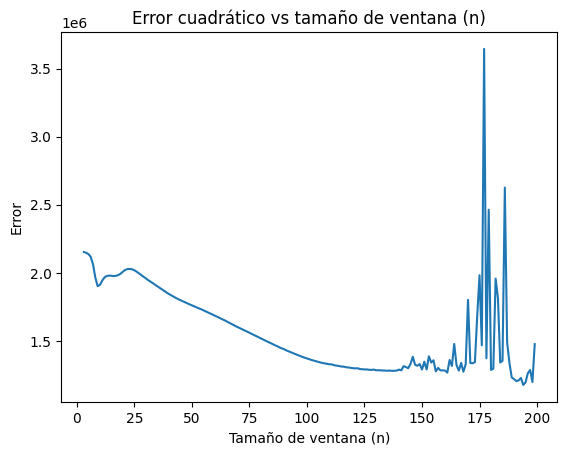

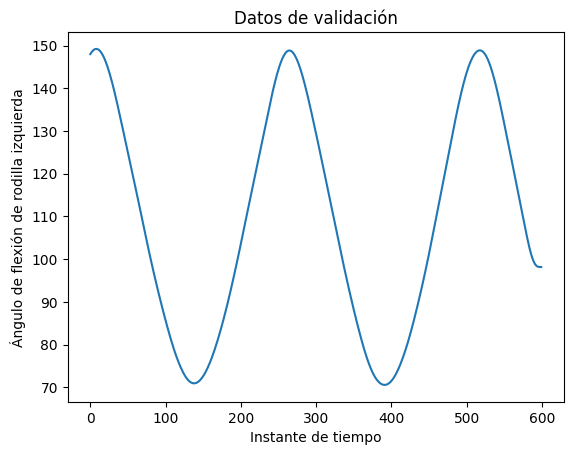

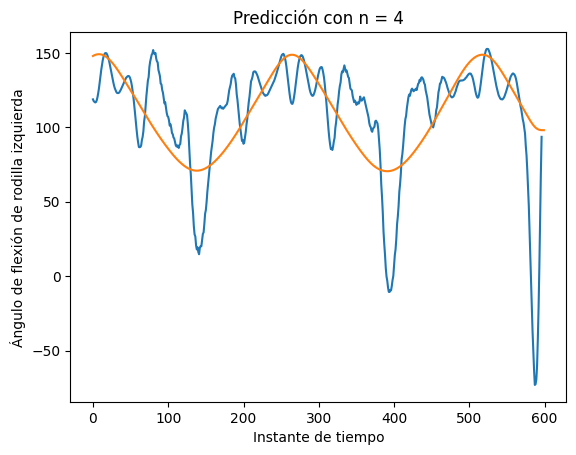

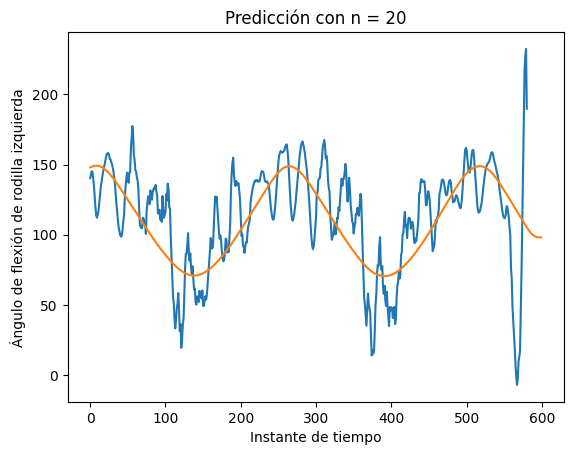

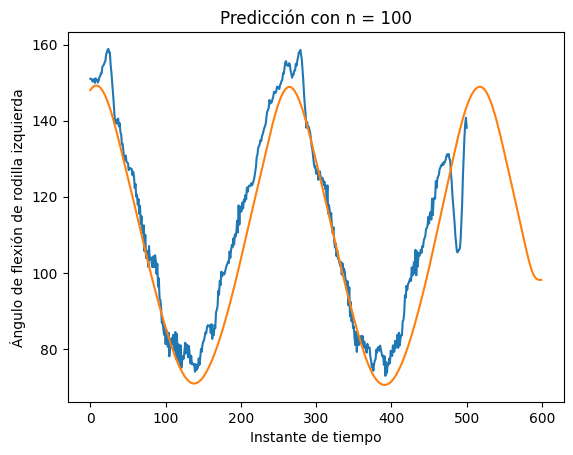

In [316]:

def get_error(real_data, beta, h, n):
    error = np.linalg.norm(real_data-np.dot(h,beta))**2
    return error

errors_list = []

for i in range(len(beta_star_list)):
    n = n_list[i]
    error = get_error(val_data_lk[:len(val_data_lk)-n+1], beta_star_list[i], get_h_and_y((val_data_lk, val_data_rk), n)[0], n)
    errors_list.append(error)
    if n in n_to_graph:
        print(f"Error para n = {n}: {error}")
    
# Graficar errores
plt.plot(n_list, errors_list)
plt.xlabel("Tamaño de ventana (n)")
plt.ylabel("Error")
plt.title("Error cuadrático vs tamaño de ventana (n)")
plt.show()

# Datos de validación
plt.plot(list(range(len(val_data_lk))), val_data_lk)
plt.xlabel("Instante de tiempo")
plt.ylabel("Ángulo de flexión de rodilla izquierda")
plt.title("Datos de validación")
plt.show()

for i in range(len(predictions_list)):
    n = n_list[i]
    if n in n_to_graph:
        plt.figure()
        plt.plot(list(range(len(predictions_list[i]))), predictions_list[i])
        plt.plot(list(range(len(val_data_lk))), val_data_lk)
        plt.xlabel("Instante de tiempo")
        plt.ylabel("Ángulo de flexión de rodilla izquierda")
        plt.title(f"Predicción con n = {n}")
        plt.show()

8. Responda las siguientes preguntas:
 - ¿Cómo afecta el tamaño de ventana a la precisión en la predicción? \
Al incrementar el tamaño de ventana la precisión en la predicción aumenta según los resultados del error cuadrático. Sin embargo, al hacer pruebas con tamaños de ventana (aprox. $n > 140$ con los datos de la práctica) el error cuadrático vuelve a aumentar, por lo que a partir de las pruebas realizadas se puede concluir que el tamaño de ventana ideal es un valor que no mejora siempre que se incrementa $n$. Puede que al aumentar $n$ hasta cierto valor se mejore la predicción, pero a partir de ese valor, si se sigue aumentando $n$, la precisión de la predicción deja de tender a mejorar (ver gráfica "Error cuadrático vs tamaño de ventana (n)").
 - ¿Qué ventajas y desventajas tiene aumentar el tamaño de ventana? \
La ventaja de aumentar el tamaño de ventana $n$ es que la predicción tiende a mejorar según el error cuadrático obtenido. La desventaja de escoger un $n$ mayor es que la predicción se calcula para un menor número de instantes de tiempo, y una vez $n$ se aumenta bastante la tendencia de mejora de la predicción se pierde (ver gráfica "Error cuadrático vs tamaño de ventana (n)").
 - ¿Cree que el sujeto requiere un ajuste en la bicicleta? \
Sí, consideramos que el sujeto debe realizar un ajuste a la bicicleta debido a que en los datos entregados inicialmente (train) se observa que este realiza un esfuerzo mayor con una rodilla que con la otra. Esto último se puede deducir gracias a que en la gráfica el ángulo de flexión alcanzado por la rodilla izquierda es más grande que el de la rodilla derecha en la mayoría de tiempos.
 - ¿Qué pasaría si se tuvieran menos datos de entrenamiento que de predicción? \
En caso de tener menos datos de entrenamiento que de predicción, el error sería de mayor magnitud, ya que para tiempos futuros no habría información suficiente, por lo que la predicción se encontría muy alejada del valor real.
